# Overview

This notebook illustrates the process taken to find a model that can predict user sentiment with relative accuracy. Machine learning models are used to predict an individual's belief in climate change based on historical tweet data and the F1 score is the measure used to evaluate the accuracy of these models.

# Outline

- [Introduction](#Introduction)
- [Import necessary libraries](#Import)
- [Loading Datasets](#Load)
- [Data Preprocessing](#section-four)
- [Exploratory Data Analysis](#EDA)
   * [Target variable analysis](#Target)
   * [Hashtags analysis](#Hashtags)
   * [Sentiment Analysis](#Sentiment)
   * [Word Frequency per class](#Frequency)
   * [Mentions for sentiment class](#Mentions)
  
- [Classification Models](#models)  
- [Feature Egineering](#feature_engineering)
  * [TF-IDF](#tfidf)
  * [CountVectorizer](#count) 
- [Pipelines](#Pipelines)
  * [Building Classification Pipelines](#classifiers)
  * [Building Models](#build)
  * [Training Models](#training)
- [Modelling and Evaluation](#model_eval)
- [Model Comparison](#compare)
- [Ensemble Method](#ensemble)
- [Hyperparameter tunning](#tunning)
- [Final model selection](#final)
- [Predictions](#predictions)
- [Submission](#submission)  
- [Conclusion](#conclusion)
- [Appendix](#appendix)
- [References](#references)
    

# Introduction

### <center> Challenge: Climate Change Belief Analysis

#  2201FT_GM2 Classification

**Team GM2** was challenged by EDSA(Explore Data Science Academy), with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based solely on their novel tweet data. Supervised machine learning models, as we'll encounter inside this notebook, refer to models that improve automatically through experience. They are called "supervised", because they depend on some input to be able to produce a prediction.  

#### Background  

In a [research article](https://www.barrons.com/articles/two-thirds-of-north-americans-prefer-eco-friendly-brands-study-finds-51578661728) conducted, 19,000 customers from 28 countries where given a poll to find out how individual shopping decisions are changing. Nearly 70% of consumers in the U.S. and Canada find that it is important for a company or brand to be sustainable or eco-friendly. More than a third (40%) of the respondents globally said that they are purpose-driven consumers, who select brands based on how well they align with their personal beliefs.

Many companies are built around lessening their environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.  


#### Problem statement  

Build a machine learning model that is able to classify whether or not an individual believes in man-made climate change based on historical tweet data to increase insights about customers and inform future marketing strategies.

You can find the project overview [here](https://www.kaggle.com/competitions/edsa-climate-change-belief-analysis-2022/overview).

## 1. Importing packages 
<a id='imp_pac'></a>
[Back to table of contents](#toc)

This notebook requires some packages that may not be installed on your local machine. Below we provide a list of packages to be installed (if they are not yet installed) as well as the code to install them.  

Run the following commands within Git bash (Windows), terminal (Mac/Linux):  

- Comet_ml - `pip install comet_ml==3.1.9`    
- Wordcloud - `pip install wordcloud==1.7.0`  
- Emoji - `pip install emoji==0.5.4`  
- Pyspellchecker - `pip install pyspellchecker==0.5.4`  
- Ftfy - `pip install ftfy==5.7`  

<a id="comet"></a>
# Starting a Comet experiment
<img src="https://www.comet.ml/images/logo_comet_light.png" width="350" alt="Drawing" style="width: 350px;"/>
We will be using Comet as a form of version control throughout the development of our model

<a id='Import'></a>
# Import necessary libraries

In [1]:
# downloads
#!pip install parfit
!pip install scikit-plot
#!pip install contractions


# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.pipeline import Pipeline
import pickle


# feature extractioin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing
#import contractions
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Hyperparameter tunning methods
#import parfit.parfit as pf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# imports for data visualisation
import seaborn as sns
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from sklearn.metrics import plot_roc_curve
#from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from scikitplot.metrics import plot_roc, plot_confusion_matrix
%matplotlib inline

<a id='Load'></a>
# Load and view the data

In [3]:
#Import data
test = pd.read_csv("test_with_no_labels.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")

In [25]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [6]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [7]:
sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


## 3. Data description
<a id='ddescribe'></a>
[Back to table of contents](#toc)

The datasets that will be used in this classification project aggregates tweets pertaining to climate change, collected between Apr 27, 2015 and Feb 21, 2018. The train dataset consists of 3 columns; "tweetid", "sentiment" and "message", where we set "tweetid" to be the index of the dataset. A description of each variable in the dataset is given below.  
### Training set
**Variable definitions:**  

- **tweetid** - Unique Twitter ID .
- **message** - Tweet body.       
- **sentiment** - Sentiment of tweet.  

**Each tweet is then labeled as one of the following classes:**  
 
    
| **Class** | **Tag** | **Description** |
|:---------:|:----------------:|:----------------|
|   **2**   | **News** |The tweet links to factual news about climate change |
|   **1**   | **Pro** |The tweet supports the belief of man-made climate change |
|   **0**   | **Neutral** |The tweet neither supports nor refutes the belief of man-made climate change |
|  **-1**   | **Anti** |The tweet does not believe in man-made climate change |  

### Testing set  
During testing we do not have access to the **tweetid** variable, but the testing dataset remains the same as the training dataset otherwise.  

### Data types 

Let's get quick overview of the datasets we will be working with throughout the notebook. The output below contains the shape of the dataset, a list of all columns with their data types and the number of non-null values present in each column.  

**Train data**  

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The train dataset has 15819 entries, contains no null entries, and the data types for "sentiment" and "message" are integer and object respectively.

**Test data**

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


The test dataset has 10546 entries, contains no null entries, and the variable "message" has the object data type.

# Data Preprocessing

In [10]:
#Data Preprocessing
#Identifying missing values and data types
train.isna().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   sentiment  15819 non-null  bool 
 1   message    15819 non-null  bool 
 2   tweetid    15819 non-null  bool 
dtypes: bool(3)
memory usage: 46.5 KB


In [11]:
test.isna().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   message  10546 non-null  bool 
 1   tweetid  10546 non-null  bool 
dtypes: bool(2)
memory usage: 20.7 KB


In [4]:
# Part of Speech for modeling
def POS(word):
    pos_counts = Counter()
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts["n"] = len([i for i in probable_part_of_speech if i.pos()=="n"])
    pos_counts["v"] = len([i for i in probable_part_of_speech if i.pos()=="v"])
    pos_counts["a"] = len([i for i in probable_part_of_speech if i.pos()=="a"])
    pos_counts["r"] = len([i for i in probable_part_of_speech if i.pos()=="r"])
    part_of_speech = pos_counts.most_common(1)[0][0]
    return part_of_speech

**Extract Useful Data**

In [5]:
def extractor(df):
    # Extract hashtags
    tweets = df['message']
    df['hashtags'] = df.message. str.lower().str.findall(r'#.*?(?=\s|$)')
    htags = df['hashtags']
    df['hashtags'] = htags.apply(lambda x: np.nan if len(x) == 0 else x)
    
    # Extract mentions
    df['mentions'] = df.message. str.lower().str.findall(r'@\w*')
    mtags = df['mentions']
    df['mentions'] = mtags.apply(lambda x: np.nan if len(x) == 0 else x)
    
    # Extract url
    df['url'] = df.message. str.lower().str.findall(r'http\S+|www.\S+')
    urltags = df['url']
    df['url'] = urltags.apply(lambda x: np.nan if len(x) == 0 else x)
    
    return df

In [6]:
extractor(train)

,sentiment,message,tweetid,hashtags,mentions,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,NaN,[@mashable],[https://t.co/yelvcefxkc]
1,1,It's not like we lack evidence of anthropogeni...,126103,NaN,NaN,NaN
2,2,RT @RawStory: Researchers say we have three ye...,698562,NaN,[@rawstory],"[https://t.co/wdt0kdur2f, https://t.co/z0anpt…]"
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,[#todayinmaker#],NaN,[https://t.co/44wotxtlcd]
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,[#electionnight],[@soynoviodetodas],NaN
...,...,...,...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001,NaN,[@ezlusztig],[https://…]
15815,2,RT @washingtonpost: How climate change could b...,17856,NaN,[@washingtonpost],[https://t.co/rpfgvb2plq]
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248,NaN,NaN,[https://t.co/0mp2]
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732,[#agenda2030.],[@sara8smiles],NaN


**Remove Unnecessary Information on Message**

In [7]:
# Remove URLs
train['message'] = train['message'].str.replace('http\S+|www.\S+', '', regex=True)

# Remove mentions
train['message'] = train['message'].str.replace('@\w*', '', regex=True)

# Removal hashtags
train['message'] = train['message'].str.replace('#.*?(?=\s|$)', '', regex=True)

# Remove 'RT'
train['message'] = train['message'].str.replace('RT', '', regex=True)

# Remove stopwords
train.head()

,sentiment,message,tweetid,hashtags,mentions,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,NaN,[@mashable],[https://t.co/yelvcefxkc]
1,1,It's not like we lack evidence of anthropogeni...,126103,NaN,NaN,NaN
2,2,: Researchers say we have three years to act ...,698562,NaN,[@rawstory],"[https://t.co/wdt0kdur2f, https://t.co/z0anpt…]"
3,1,WIRED : 2016 was a pivotal year in the war on...,573736,[#todayinmaker#],NaN,[https://t.co/44wotxtlcd]
4,1,": It's 2016, and a racist, sexist, climate ch...",466954,[#electionnight],[@soynoviodetodas],NaN


In [8]:
# Clean tweets
def clean_tweets(df):
    # tokenizing the tweets
    clean_tweets = df['message'].apply(TweetTokenizer().tokenize)

    # remove punctuation
    clean_tweets = clean_tweets.apply(lambda x : [token for token in x if token not in string.punctuation])

    # removing digits from the tweets
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if token not in list(string.digits)])

    # lastly we remove all one character tokens
    clean_tweets = clean_tweets.apply(lambda x: [token for token in x if len(token) > 1])
    
    df['cleaned_tweets'] = clean_tweets
    
    return df['cleaned_tweets']

In [9]:
clean_tweets(train)

0        [PolySciMajor, EPA, chief, doesn't, think, car...
1        [It's, not, like, we, lack, evidence, of, anth...
2        [Researchers, say, we, have, three, years, to,...
3        [WIRED, 2016, was, pivotal, year, in, the, war...
4        [It's, 2016, and, racist, sexist, climate, cha...
                               ...                        
15814    [They, took, down, the, material, on, global, ...
15815    [How, climate, change, could, be, breaking, up...
15816    [notiven, nytimesworld, What, does, Trump, act...
15817    [Hey, liberals, the, climate, change, crap, is...
15818         [climate, change, equation, in, screenshots]
Name: cleaned_tweets, Length: 15819, dtype: object

In [10]:
#Removing Stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

# Convert to lower case
train['cleaned_tweets'] = train['cleaned_tweets'].apply(lambda x: [word.lower() for word in x])

# Remove stopwords
train['no_stopwords'] = train['cleaned_tweets'].apply(lambda x: [item for item in x if item not in stop])

train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tebel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,NaN,[@mashable],[https://t.co/yelvcefxkc],"[polyscimajor, epa, chief, doesn't, think, car...","[polyscimajor, epa, chief, think, carbon, diox..."
1,1,It's not like we lack evidence of anthropogeni...,126103,NaN,NaN,NaN,"[it's, not, like, we, lack, evidence, of, anth...","[like, lack, evidence, anthropogenic, global, ..."
2,2,: Researchers say we have three years to act ...,698562,NaN,[@rawstory],"[https://t.co/wdt0kdur2f, https://t.co/z0anpt…]","[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,..."
3,1,WIRED : 2016 was a pivotal year in the war on...,573736,[#todayinmaker#],NaN,[https://t.co/44wotxtlcd],"[wired, 2016, was, pivotal, year, in, the, war...","[wired, 2016, pivotal, year, war, climate, cha..."
4,1,": It's 2016, and a racist, sexist, climate ch...",466954,[#electionnight],[@soynoviodetodas],NaN,"[it's, 2016, and, racist, sexist, climate, cha...","[2016, racist, sexist, climate, change, denyin..."


In [11]:
#Most Frequent Words
from collections import Counter
cnt = Counter()
for message in train['no_stopwords'].values:
    for word in message:
        cnt[word] += 1
        

In [12]:
#Map the sentiment class by name
train['sent_labels']  = train['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})

In [14]:
#The length of each raw tweet
train['text_length'] = train['message'].apply(lambda x: len(x))

**Separate Datframes of Tweets for each Sentiment**

In [15]:
# Dataframe for neutral tweets
neutral_df = train[train['sentiment'] == 0]
neutral_df.head()

,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords,sent_labels,text_length
19,0,Calum: *tweets abt reunitingish w the cast*\r\...,547924,NaN,NaN,NaN,"[calum, tweets, abt, reunitingish, the, cast, ...","[calum, tweets, abt, reunitingish, cast, sees,...",Neutral,142
22,0,"we also met this guy, he let us in on some tru...",67545,NaN,NaN,[https://t.co/q7yomcmzaj],"[we, also, met, this, guy, he, let, us, in, on...","[also, met, guy, let, us, truth, climate, chan...",Neutral,98
30,0,are these the same scientists that denounce c...,365051,NaN,[@jnp_ftw],NaN,"[are, these, the, same, scientists, that, deno...","[scientists, denounce, climate, change, choice]",Neutral,78
39,0,We’ ve dealt with simple issues like climate c...,403368,[#qanda],NaN,NaN,"[we, ve, dealt, with, simple, issues, like, cl...","[dealt, simple, issues, like, climate, change,...",Neutral,109
43,0,: Win probability is bullshit man. I saw the ...,326916,NaN,[@andrewsharp],NaN,"[win, probability, is, bullshit, man, saw, the...","[win, probability, bullshit, man, saw, nba, fi...",Neutral,106


In [16]:
# Dataframe for pro tweets
pro_df = train[train['sentiment'] == 1]
pro_df.head()

,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords,sent_labels,text_length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,NaN,[@mashable],[https://t.co/yelvcefxkc],"[polyscimajor, epa, chief, doesn't, think, car...","[polyscimajor, epa, chief, think, carbon, diox...",Pro,108
1,1,It's not like we lack evidence of anthropogeni...,126103,NaN,NaN,NaN,"[it's, not, like, we, lack, evidence, of, anth...","[like, lack, evidence, anthropogenic, global, ...",Pro,62
3,1,WIRED : 2016 was a pivotal year in the war on...,573736,[#todayinmaker#],NaN,[https://t.co/44wotxtlcd],"[wired, 2016, was, pivotal, year, in, the, war...","[wired, 2016, pivotal, year, war, climate, cha...",Pro,62
4,1,": It's 2016, and a racist, sexist, climate ch...",466954,[#electionnight],[@soynoviodetodas],NaN,"[it's, 2016, and, racist, sexist, climate, cha...","[2016, racist, sexist, climate, change, denyin...",Pro,90
5,1,Worth a read whether you do or don't believe i...,425577,NaN,NaN,"[https://t.co/gglzvnyjun, https://t.co/7afe2ma...","[worth, read, whether, you, do, or, don't, bel...","[worth, read, whether, believe, climate, change]",Pro,64


In [17]:
# Dataframe for anti tweets
anti_df = train[train['sentiment'] == -1]
anti_df.head()

,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords,sent_labels,text_length
28,-1,Sally Kohn’s latest evidence of climate change...,355491,NaN,[@twitchyteam],[https://t.co/mhkzogl9vt],"[sally, kohn, latest, evidence, of, climate, c...","[sally, kohn, latest, evidence, climate, chang...",Anti,104
46,-1,Carbon Tax is a Globalist idea to enslave the...,61141,NaN,[@realdonaldtrump],NaN,"[carbon, tax, is, globalist, idea, to, enslave...","[carbon, tax, globalist, idea, enslave, world'...",Anti,121
48,-1,: We had winds close to 100 MPH in the area t...,719523,NaN,[@stevesgoddard],NaN,"[we, had, winds, close, to, 100, mph, in, the,...","[winds, close, 100, mph, area, afternoon, woul...",Anti,120
56,-1,lmao 😂 snowflakes ❄️ complaining about snowfl...,911385,NaN,[@misslizzynj],NaN,"[lmao, snowflakes, complaining, about, snowfla...","[lmao, snowflakes, complaining, snowflakes, wi...",Anti,84
57,-1,: This is ONE of Arnold Schwarzenegger's vehi...,768263,NaN,[@dawn2334dawn],[http…],"[this, is, one, of, arnold, schwarzenegger's, ...","[one, arnold, schwarzenegger's, vehicles, whin...",Anti,122


In [19]:
# Dataframe for news tweets
news_df = train[train['sentiment'] == 2]
news_df.head()

,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords,sent_labels,text_length
2,2,: Researchers say we have three years to act ...,698562,NaN,[@rawstory],"[https://t.co/wdt0kdur2f, https://t.co/z0anpt…]","[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...",News,86
12,2,: We only have a 5 percent chance of avoiding...,454673,NaN,[@tveitdal],"[https://t.co/xubtqnxhkk, https://t.co/of…]","[we, only, have, percent, chance, of, avoiding...","[percent, chance, avoiding, dangerous, global,...",News,90
14,2,Fossil fuel giant ExxonMobil ‘misled’ the publ...,658092,NaN,NaN,[https://t.co/ofc2wsu4ex],"[fossil, fuel, giant, exxonmobil, misled, the,...","[fossil, fuel, giant, exxonmobil, misled, publ...",News,98
26,2,Bangladesh confronting climate change head on,365291,NaN,NaN,"[https://t.co/mtqenbqdut, https://t.co/itgkuxg...","[bangladesh, confronting, climate, change, hea...","[bangladesh, confronting, climate, change, head]",News,47
32,2,: Atmospheric rivers fueled by climate change...,143471,NaN,[@latimes],"[https://t.co/p0lzbhlu5k, https://t…]","[atmospheric, rivers, fueled, by, climate, cha...","[atmospheric, rivers, fueled, climate, change,...",News,97


<a id='EDA'></a>
# Exploratory Data Analysis 

In this section we want to apply a variety of techniques to maximize specific insights into a dataset, reveal underlying structure, extract significant variables, detect outliers and anomalies, test assumptions, develop models, and determine best parameters for estimations. In essence, we want to dig deeper into our dataset to more insights about its behaviour!

<a id='Target'></a>
### Explore the target variable

We want to understand the behaviour of our target variable for our respective categories...let's dig in ⛏!

Percentage contribution:
 Pro        53.922498
News       23.010304
Neutral    14.874518
Anti        8.192680
Name: sent_labels, dtype: float64


None

C:\Users\tebel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


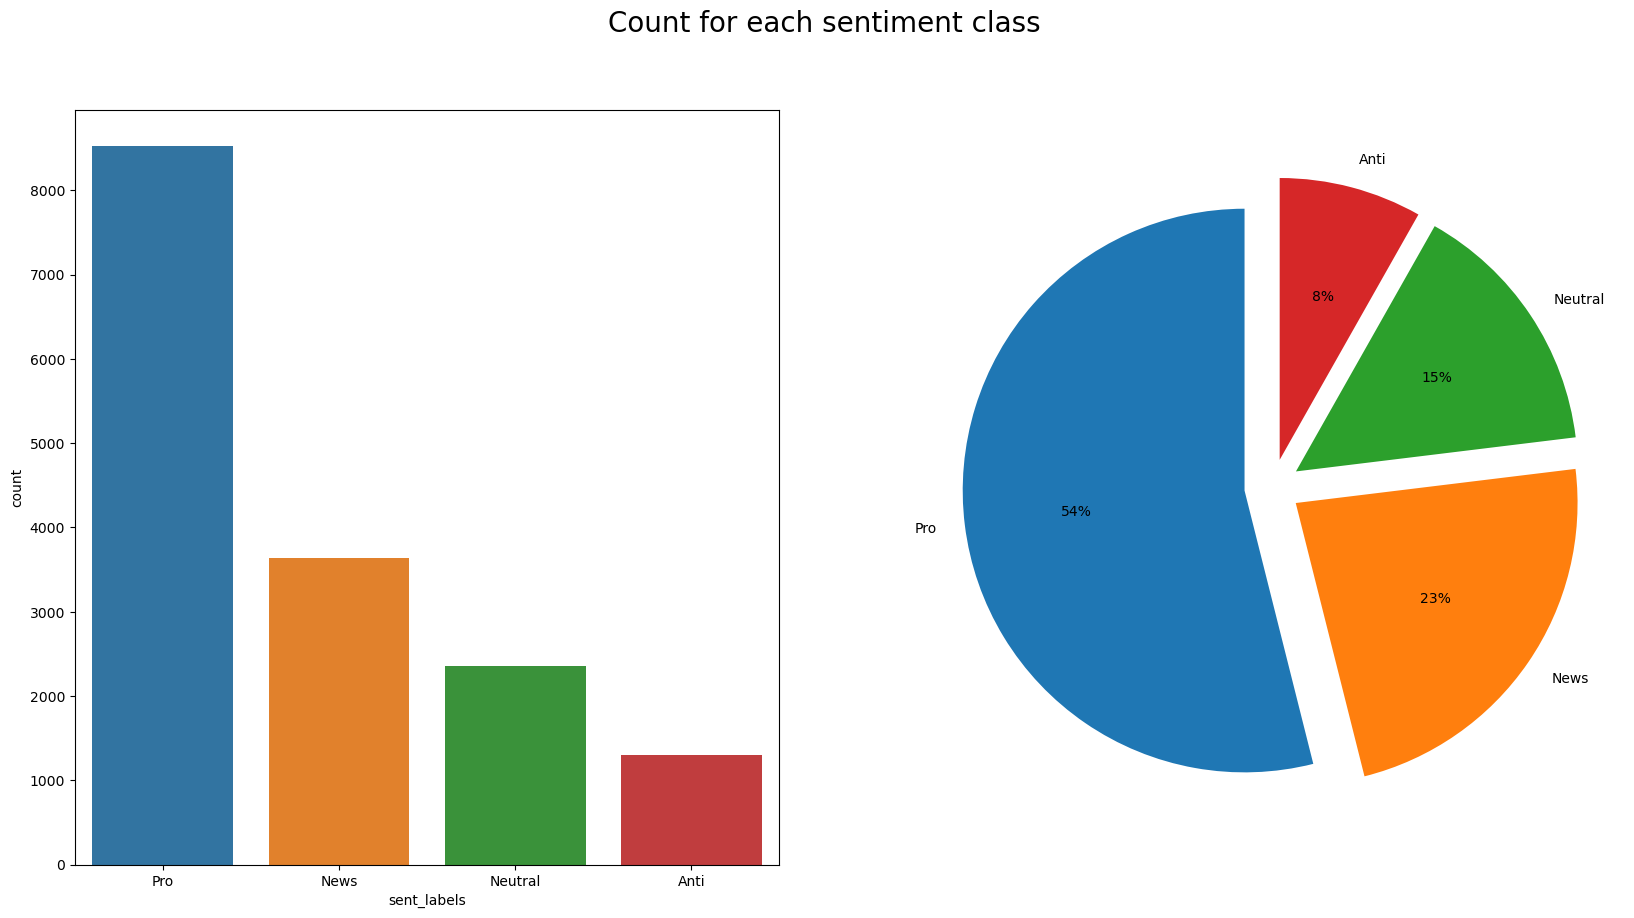

In [40]:
# Display target distribution

display(print("Percentage contribution:\n",train.sent_labels.value_counts(normalize=True)*100))

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(train['sent_labels'], ax=axes[0])

code_labels=['Pro', 'News', 'Neutral', 'Anti']
axes[1].pie(train['sent_labels'].value_counts(),
            labels= code_labels,
            autopct='%1.0f%%',
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Count for each sentiment class', fontsize=20)
plt.show()

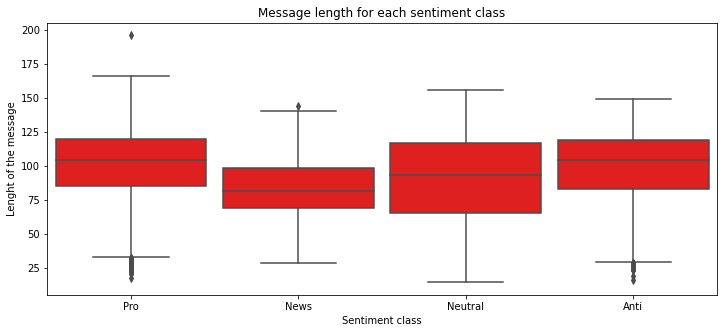

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

sns.boxplot(x=train['sent_labels'], y=train['text_length'], 
            data=train, width = 0.9, color = 'red')
plt.ylabel('Lenght of the message')
plt.xlabel('Sentiment class')
plt.title('Message length for each sentiment class')
plt.show()

#### Quick observations:
* There is a strong imbalance for our sentiment classes
* Sentiment class '1' (Pro) dominates the chart with over 50% contribution, while class '-1' (Anti) lags behind with 8%.
* The text length is dependent on the character limit of each tweet on Twitter. Character limit used to be 140, but it increased to 280 characters in late 2017.
* There are evident outliers in all classes, except for 'neutral' sentiment where all the data is taken in.
* It is evident that the 'pro' class had a lot to say to express their opinion, as shown by more lenghty message in the outliers. 

In [42]:
# Print a Sample tweet
tweet = train.iloc[4,1]
print(tweet)

 : It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. 


In [43]:
# Checking whether a character is white-space character or not
print(len(train['message']))
print(sum(train['message'].apply(lambda x: x.isspace())))

15819
0


In [22]:
!pip install langdetect

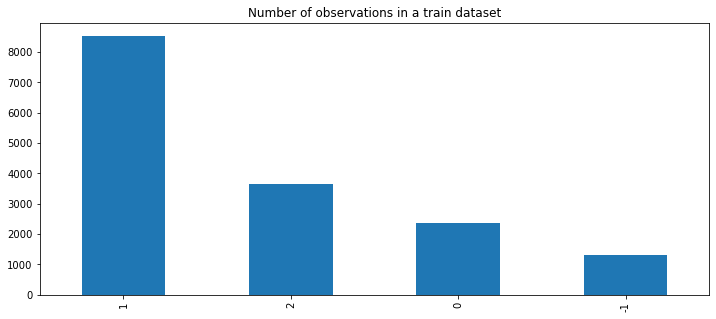

In [44]:
train.sentiment.value_counts().plot(kind='bar')
plt.title('Number of observations in a train dataset')
plt.show()

The graph above shows an imbalance of texts

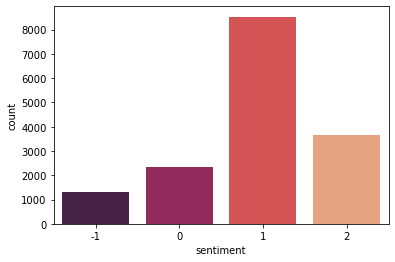

In [33]:
sns.countplot(x='sentiment',data=train,palette='rocket')
plt.show()

Check the distribution of data

Plot list of common words

In [45]:
#convert the test to numerical values 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df.message)

sum_words = words.sum(axis=0)
#create a frequency of most occuring words
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create a dataframe of the words and frequency 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = '#440154')
plt.title("Train data : Most Common Occuring Words - Top 30",size=15)
plt.show()

NameError: name 'train_df' is not defined

We can see we used "climate" and "change" more than twice other words, followed by "global" and "warning", then "trump" while others are almost the same.

<a id='Hashtags'></a>
### Hashtags for sentiment classes
`Hashtags` are the best way used on twitter to link the conversions of similar content. Hashtags encourage social media users to explore content that catches their eye. Companies can use hashtags to reach their target audience and to help members filter information. It is for this reason that we will then collect most sed hashtags for each sentiment class. 

In [20]:
# Create hashtag df and remove nulls 
def hashtags(df):
    '''
    This function takes in a dataframe as input.
    It returns dataframe with no null values.
    '''
    df = df[['hashtags', 'sent_labels']]
    df = df[df['hashtags'].notnull()]
    return df

In [47]:
hashtags(news_df).head()

,hashtags,sent_labels
49,[#climate],News
133,[#climatechange],News
190,"[#climatechange, #p2]",News
191,[#climate],News
208,[#skpol…],News


In [21]:
def hashtag_count(df):
    '''
    This function takes a dataframe as input.
    It returns a dataframe with count for hashtags.
    '''
    hashtag = sum(df['hashtags'], [])
    count = nltk.FreqDist(hashtag)  
    hashtag = pd.DataFrame({'hashtags': list(count.keys()),
                           'count': list(count.values())})
    hashtag = hashtag.nlargest(20, columns="count")

    return hashtag

In [49]:
hashtag_count(hashtags(news_df)).head()

,hashtags,count
0,#climate,132
1,#climatechange,61
5,#environment,45
22,#news,31
56,#trump,19


In [50]:
# Visualize the count for each class
def hastag_plot(df, x):
    '''
    This function plots a barplot for an iput dataframe, 
    given x as the title of the plot.
    '''
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, y =df['hashtags'], x =df['count'], orient='h', color = 'orange')
    plt.title(x,fontsize=14)
    plt.xlabel('Hashtag Count')
    plt.ylabel('Hashtags Used')
    return plt.show()

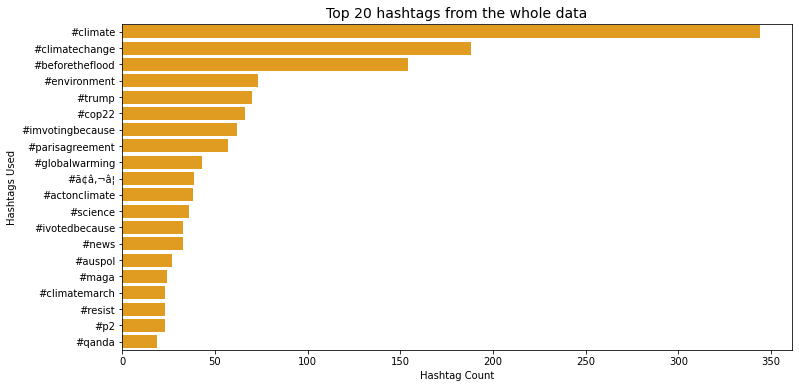

In [51]:
hastag_plot(hashtag_count(hashtags(train)), x = 'Top 20 hashtags from the whole data')

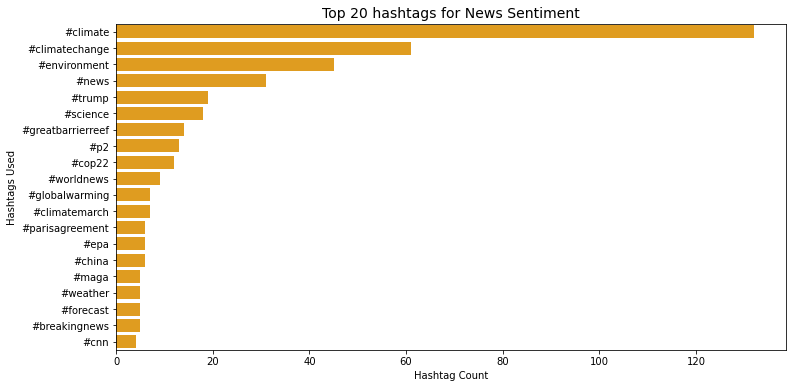

In [52]:
hastag_plot(hashtag_count(hashtags(news_df)), x = 'Top 20 hashtags for News Sentiment')

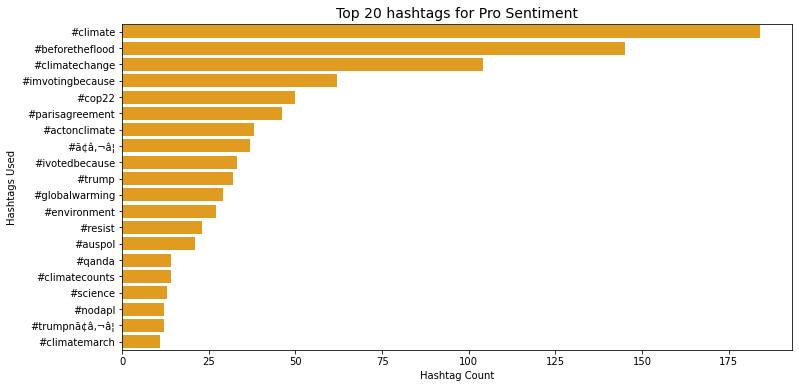

In [45]:
hastag_plot(hashtag_count(hashtags(pro_df)), x = 'Top 20 hashtags for Pro Sentiment')

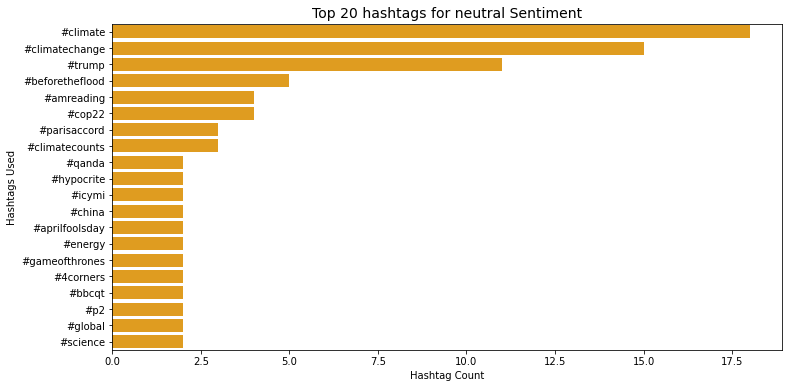

In [46]:
hastag_plot(hashtag_count(hashtags(neutral_df)), x = 'Top 20 hashtags for neutral Sentiment')

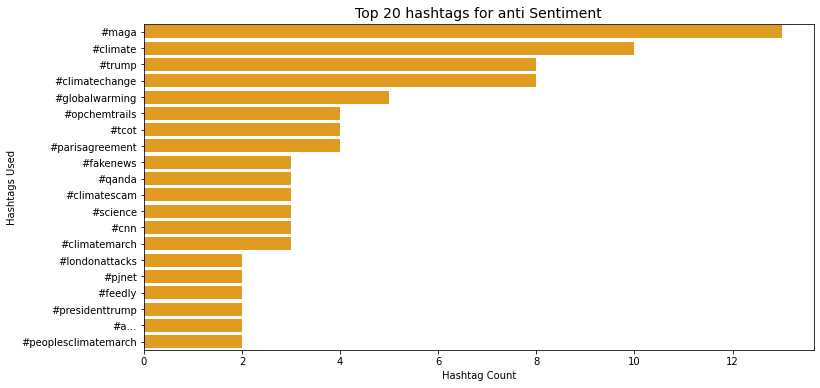

In [47]:
hastag_plot(hashtag_count(hashtags(anti_df)), x = 'Top 20 hashtags for anti Sentiment')

##### Quick Insights:
`Top 5 Hashtags Summary:`

|Overall |News|Pro|Neutral|Anti|
|:-----|:----:|----:|----:|----:|
|#climate |#climate |#climate |#climate |#maga |
|#climatechange |#climatechange |#beforetheflood |#climatechange |#climate |
|#beforetheflood |#environment |#climatechange |#trump |#trump |
|#environment |#news |#imvotingbecause |#beforetheflood |#climatechange |
|#trump |#trump |#cop22 |#amreading |#globalwarming |


* Overall, #climatechange and #climate are at the top of the charts as expected, they are the words used to identify tweets that identify climate change content.
* #BeforeTheFlood was trending in the year 2016 following the documentray by Actor Leonardo DiCaprio with scientists, activists and world leaders to discuss the dangers of climate change and possible solutions.
* In the same year; 2016, the outgoing president of U.S.A was canvassing for presidency and he had made his stand clear on Climate Change clear to the public describing it as a "hoax". That accounts for his name appearing across all sentiment classes.
* In his campaign, he used the slogan #MAGA which stands for "Make America Great Again". This appears to have attracted more tweets for tweets in the 'anti' class, making it to the top spot.
* It is for this reason that #iamvotingbecause was at the top for 'pro' class as it was election year in the United States of America.
* We can notice that #cop22 also made it to top 5 in the 'pro' class. COP22 (Conference of the Parties) represents the United Nations Climate Change Conference in 2016.

<a id='models'></a>
# Classification Models
We're going to look at the following models:

*  Decision Tree Classifier
*  RandomForest Classifier
*  LinearSVC(Support Vector Classifier)
*  Support Vector Classifier
*  Logistic Regression
*  Stochastic Gradient Descent (SGD)
*  Ridge Classiffier


<a id='DC'></a>
### Decision Tree Classifier
A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are extremely intuitive ways to classify objects or predict continuous values: you simply ask a series of questions designed to zero-in on the classification/prediction.Overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. This issue can be addressed by using random forests.
![1*bcLAJfWN2GpVQNTVOCrrvw.png](https://miro.medium.com/max/688/1*bcLAJfWN2GpVQNTVOCrrvw.png)


<a id='random'></a>
### Random Forest Classifier
A random forest is a powerful non-parametric algorithm that is an example of an ensemble method built on decision trees, meaning that it relies on aggregating the results of an ensemble of decision trees. The ensemble of trees are randomized and the output is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
![voting_dnjweq.jpg](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)



## Support Vector Classification(LinearSVC)
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes as seen in the diagram below

![1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg](https://miro.medium.com/max/963/1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg)

To better explain the concept of `SVM` we will look at a case of two classes.

**To find the best line seperating the classes**

The `SVM` algorithm finds the points closest to the line from both the classes.These points are called support vectors, then it compute the distance between the line and the support vectors, This distance is called the margin. Our goal is to maximize the margin.

In a case for more than two classes the goal is to find the the best hyperplane that seperates the classes.
The hyperplane for which the margin is maximum is the optimal hyperplane.

We wil be looking at two Support Vector Classifer models namely SVC and LinearSVC, the main differences between these two are as follows
- By default scaling, LinearSVC minimizes the squared hinge loss while SVC minimizes the regular hinge loss.
- LinearSVC uses the One-vs-All (also known as One-vs-Rest) multiclass reduction while SVCuses the One-vs-One multiclass reduction.

## Logistic Regression

**Logistic regression** is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. For example, it can be used for cancer detection problems. It computes the probability of an event occurrence.

Logistic Regression uses the probability of a data point to belonging to a certain class to classify each datapoint to it's best estimated class

Logistic regression has been rated as the best performing model for linearly separable data especially if it's predicting binary data(Yes & NO or 1 & 0), and performs better when there's no class imbalance.

The figure below is the sigmoid function logistic regression models use to make predictions:
![1*QY3CSyA4BzAU6sEPFwp9ZQ.png](http://miro.medium.com/max/725/1*QY3CSyA4BzAU6sEPFwp9ZQ.png)



Advantages
* Convenient probability scores for observations (probability of each outcome is transformed into a classification);
* Not a major issue if there is collinearity among features (much worse with linear regression).

Disadvantages
* Can overfit when data is unbalanced (i.e.: we have far more observations in one class than the other).
* Doesn't handle large number of categorical variables well.

## Stochastic Gradient Descent

**Stochastic Gradient Descent (SGD)** is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

in Stochastic Gradient Descent, a few samples are selected randomly instead of the whole data set for each iteration.

The advantages of Stochastic Gradient Descent are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).


The disadvantages of Stochastic Gradient Descent include:
* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* SGD is sensitive to feature scaling.

## Ridge Classifier

This Ridge classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case) 

Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When
multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from
the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.
It is hoped that the net effect will be to give estimates that are more reliable. Another biased regression technique,
principal components regression, is also available in NCSS. Ridge regression is the more popular of the two
methods.

<a id='feature_engineering'></a>
# Feature Engineering
We will be looking at two methods of generating features namely, `tfidfVectorizer` and `CountVectorizer`


<a id='tfidf'></a>
### TFIDF

`TF-IDF` stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.
This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.
`vocabulary_` Is a dictionary that converts each word in the text to feature index in the matrix, each unique token gets a feature index.
 

<a id='count'></a>
### CountVectorizer

The `CountVectorizer` provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary by creating a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix.

In [22]:
# Data preprocessing for model building

train = train.copy()
test = test.copy()
normalizer = WordNetLemmatizer()
nltk.download('wordnet')

def replace_sentiments(df):
    df['message'] = df['message'].apply(lambda x: x.replace('global', 'neutral'))
    df['message'] = df['message'].apply(lambda x: x.replace('climate', 'positive'))
    df['message'] = df['message'].apply(lambda x: x.replace('MAGA', 'negative')) 

    return df['message']

train['message'] = replace_sentiments(train)
test['message'] = replace_sentiments(test)

# cleaning tweets
train['clean_tweets'] = clean_tweets(train)
test['clean_tweets'] = clean_tweets(test)


# lemmatize
train['clean_tweets'] = train['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])
test['clean_tweets'] = test['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tebel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Creating our X and y Metrics

In [23]:
X = train['clean_tweets']
y = train['sentiment']
X_test = test['clean_tweets']

### Splitting data

Separating data into training and validation sets is an important part of evaluating our models. 
In our case we will randomly split the train data into 90% train and 10% validation. 
After our model is trained with the train data we then use it to make predictions for the target using the validation set,Because the data in the validation set already contains known values for the target variable this will make it easy  for us to asses our model's accuracy.

In [24]:
# Splitting the data into 80% train and 20% validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

In [25]:
X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))
X_test = list(X_test.apply(' '.join))

<a id='Pipelines'></a>
# Pipelines

`Pipeline`  by definition is a tool that sequentially applies a list of transforms and a final estimator. Intermediate steps of pipeline implement fit and transform methods and the final estimator only needs to implement fit. In our case pipelines will help us tranform the train, validation and test data as well as train our models.

Since our models can only process numerical data our first step is to build a pipeline that converts text data into numeric data, In this notebook we will be focusing on two methods of feature engineering, which we will use to convert text data to numeric data, namely `TfidfVectorizer` and the `CountVectorizer`, then we will train our models within these pipelines

We will be building pipelines with features generated using both `tfidfVectorizer` and the `CountVectorizer`

**CREATING PIPELINES**

In [26]:
# DecisionTreeClassifier Pipeline
tree_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])
tree_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('tree', DecisionTreeClassifier()),])


# RandomForestClassifier Pipeline
rfc_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])
rfc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('rfc', RandomForestClassifier()),])


# LinearSVC Pipeline
Lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
Lsvc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('svc', LinearSVC()),])



# Logistic Regression pipeline
logreg_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression()),])
logreg_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('logistic', LogisticRegression()),])



# SGD Classifier pipeline
SGD_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('SGD', SGDClassifier())])
SGD_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('SGD', SGDClassifier()),])




# Support Vector Classifier Pipeline
svc_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('SVC', SVC())])
svc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('SVC', SVC()),])


ridge_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('Ridge', RidgeClassifier())])
ridge_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('Ridge', RidgeClassifier()),])

<a id='train'></a>
## Training models
Each model is trained using it's custom pipeline which will take raw text data turn it into numeric data and initial the classifier with default parameters

In [27]:
# training the decision tree pipeline
tree_tfidf.fit(X_train, y_train)
tree_count.fit(X_train, y_train)

# training the RandomForest pipleline
rfc_tfidf.fit(X_train, y_train)
rfc_count.fit(X_train, y_train)

# training the LinearSVC pipeline
Lsvc_tfidf.fit(X_train, y_train)
Lsvc_count.fit(X_train, y_train)

# training the logistic regression pipeline
logreg_tfidf.fit(X_train, y_train)
logreg_count.fit(X_train, y_train)

# training the SGD Classifier
SGD_tfidf.fit(X_train, y_train)
SGD_count.fit(X_train, y_train)

# training the support vector classifier
svc_tfidf.fit(X_train, y_train)
svc_count.fit(X_train, y_train)

# training the Ridge classifier
ridge_tfidf.fit(X_train, y_train)
ridge_count.fit(X_train, y_train)

C:\Users\tebel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 2))),
                ('Ridge', RidgeClassifier())])

In [28]:
# calculating average scores for the TFIDF
tree_acc =  accuracy_score(y_val,tree_tfidf.predict(X_val))
rfc_acc = accuracy_score(y_val,rfc_tfidf.predict(X_val))
lsvc_acc = accuracy_score(y_val,Lsvc_tfidf.predict(X_val))
log_acc = accuracy_score(y_val, logreg_tfidf.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_tfidf.predict(X_val))
svc_acc = accuracy_score(y_val, svc_tfidf.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_tfidf.predict(X_val))

tfidf_avg_accuracy = round(np.mean([tree_acc,rfc_acc,lsvc_acc,log_acc,sgd_acc,svc_acc,ridge_acc]),4)

In [29]:
tree_acc =  accuracy_score(y_val,tree_count.predict(X_val))
rfc_acc = accuracy_score(y_val,rfc_count.predict(X_val))
lsvc_acc = accuracy_score(y_val,Lsvc_count.predict(X_val))
log_acc = accuracy_score(y_val, logreg_count.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_count.predict(X_val))
svc_acc = accuracy_score(y_val, svc_count.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_count.predict(X_val))

CountVec = round(np.mean([tree_acc,rfc_acc,lsvc_acc,log_acc,sgd_acc,svc_acc, ridge_acc]),4)

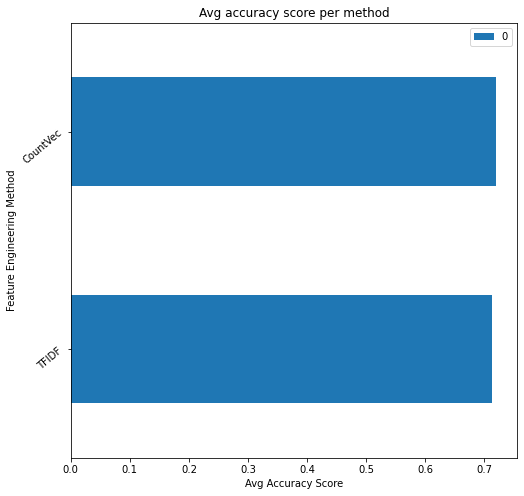

In [32]:
accuracy_dict = {'TFIDF':[tfidf_avg_accuracy], 'CountVec':[CountVec]}
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.T.plot(kind='barh', figsize = (8,8),legend = True)
plt.xlabel('Avg Accuracy Score')
plt.ylabel('Feature Engineering Method')
plt.yticks(rotation = 40)
plt.title('Avg accuracy score per method')
plt.show()

We see that on average  the models build using the `CountVectorizer` performed the best and for the remainder of this notebook we will generate our features using the `CountVectorizer`

<a id='model_eval'></a>
# Model Evaluation

### Performance Metrics for model evaluation

We will evaluate our models using the the F1 Score which is the number of true instances for each label.

#### Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations

$$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$

#### Recall

The recall is intuitively the ability of the classifier to find all the positive samples

$$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$

#### F1 Score

Weighted average of precision and recall. 

$$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$

To evaluate the base models we first start with making predictions for the validation set

In [30]:
# Making validations set predicions

tree_prediction = tree_count.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction = rfc_count.predict(X_val) # RandomForestClassifier predictions
Lsvc_prediction = Lsvc_count.predict(X_val) # LinearSVClassifier Predictions
logreg_prediction = logreg_count.predict(X_val) # Logistic regression predictions
SGD_prediction = SGD_count.predict(X_val) # SGD Classifier predictions
SVC_prediction = svc_count.predict(X_val) # Support vector machine predictions
ridge_prediction = ridge_count.predict(X_val) # Ridge predictions

### Evalution of DecisionTreeClassifier

In [83]:
print(confusion_matrix(y_val, tree_prediction))

[[  78   59  120   21]
 [  23  141  220   41]
 [  65  134 1368  188]
 [  12   39  186  469]]


**Key Observations**


Decision Tree
               precision    recall  f1-score   support

          -1       0.44      0.28      0.34       278
           0       0.38      0.33      0.35       425
           1       0.72      0.78      0.75      1755
           2       0.65      0.66      0.66       706

    accuracy                           0.65      3164
   macro avg       0.55      0.51      0.53      3164
weighted avg       0.64      0.65      0.64      3164



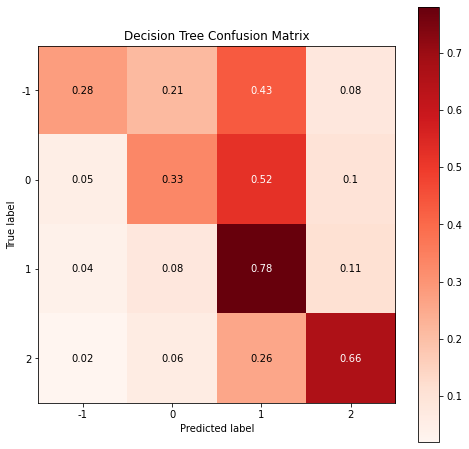

In [85]:
print('\nDecision Tree\n', classification_report(y_val, tree_prediction))
plot_confusion_matrix(y_val, tree_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Decision Tree Confusion Matrix')
plt.show()

**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.28
+ Neutral : 0.33
+ Pro : 0.78
+ News : 0.66
We see that  most of the tweets are incorrectly classified as `pro` sentiment classes, with 44% and 48% of `anti` and `neutral` sentiment classes respectively incorrectly classified to belong to `Pro` sentiment class

In [29]:
# Print the overall accuracy
decison_tree_acc = round(accuracy_score(y_val, tree_prediction),4)
print(f'\nOverall accuracy score for Decision Tree : {decison_tree_acc}')
decision_tree_f1 = round(f1_score(y_val, tree_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score Decision Tree {decision_tree_f1}' )



Overall accuracy score for Decision Tree : 0.6482

Weighted avg f1 score Decision Tree 0.6386


Overal the Decision Tree classifier did a poor job at classifying the sentiments, achieving the accuracy score of 0.6498 and a weighted F1 score of 0.6403

### Evalution of RandomForestClassifier

In [87]:
print('\nRandomForestClassifier\n', confusion_matrix(y_val, rfc_prediction))



RandomForestClassifier
 [[  54   29  191    4]
 [   2  133  283    7]
 [   8   50 1618   79]
 [   2   24  240  440]]



RandomForestClassifier
               precision    recall  f1-score   support

          -1       0.82      0.19      0.31       278
           0       0.56      0.31      0.40       425
           1       0.69      0.92      0.79      1755
           2       0.83      0.62      0.71       706

    accuracy                           0.71      3164
   macro avg       0.73      0.51      0.56      3164
weighted avg       0.72      0.71      0.68      3164



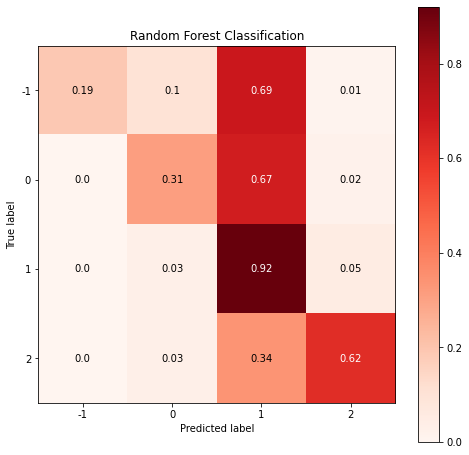

In [89]:
print('\nRandomForestClassifier\n', classification_report(y_val, rfc_prediction))
plot_confusion_matrix(y_val, rfc_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Random Forest Classification')
plt.show()

**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.19
+ Neutral : 0.31
+ Pro : 0.92
+ News : 0.62

Random Forest classifier did a bad job at correctly classifying sentiment class `anti` and `neutral` incorrectly classifying them as `pro` sentiment class 66% and 68% of the time respectively.



In [91]:
random_forest_acc = round(accuracy_score(y_val, rfc_prediction),4)
print(f'\nOveral accuracy score for RandomForestClassifier :{random_forest_acc}')
random_forest_f1 = round(f1_score(y_val, rfc_prediction, average="weighted"),4)
print(f'\nWeighted f1 score for RandomForestClassifier : {random_forest_f1}')


Overal accuracy score for RandomForestClassifier :0.7095

Weighted f1 score for RandomForestClassifier : 0.6797


The overall accuracy and weighted f1 score for the Random Forest Classifier is better compared to that of the Decision Tree classifier, making the Random Forest classifier the best model this far

### Evaluation of LinearSVClassifier

In [92]:
print('\nLinearSVC Model\n', confusion_matrix(y_val, Lsvc_prediction))


LinearSVC Model
 [[ 121   58   87   12]
 [  26  207  168   24]
 [  37  116 1439  163]
 [   3   25  129  549]]



LinearSVC Model
               precision    recall  f1-score   support

          -1       0.65      0.44      0.52       278
           0       0.51      0.49      0.50       425
           1       0.79      0.82      0.80      1755
           2       0.73      0.78      0.76       706

    accuracy                           0.73      3164
   macro avg       0.67      0.63      0.64      3164
weighted avg       0.73      0.73      0.73      3164



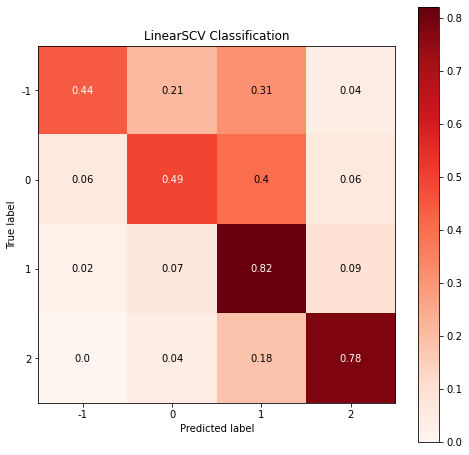

In [93]:
print('\nLinearSVC Model\n', classification_report(y_val, Lsvc_prediction))
plot_confusion_matrix(y_val, Lsvc_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('LinearSCV Classification')
plt.show()

**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.44
+ Neutral : 0.49
+ Pro : 0.82
+ News : 0.78

We see that that the LinearSVC did a very job at classifying positive samples, the biggest concern here is that 32% and 39% of `anti` and `neutral` sentiment classes respectively were incorrectly classified as `Pro` sentiment class

- We see that the LinearSVC model did a far better job at classifiying `Pro` and `News` sentiment classes compared to `Decision Tree` and `RandomForest` models  with both classes achieving an f1 score of 0.85 and 0.81 respectively
- The LinearSVC model also did a far better job at classifying `Anti` sentiment class comapred to both the Decision tree and the Randrom Forest.
- There was a slight improvement in the classification of `neutral` tweets with the LinearSVC, which is by far overshadowed by the improvements we see in other sentiments classes
- The LinearSVC has done a better job overall in classifying the sentiments, we see that `Anti` and `Neutral` sentiments have almost the same score, same applies with `Pro` and `News` sentiments which is consistent with the distribution of the data between the sentiment classes

In [94]:
linearSVC_acc = round(accuracy_score(y_val, Lsvc_prediction),4)
print(f'\nOverall accuracy score for LinearSVC Model : {linearSVC_acc}')
linearSVC_f1 = round(f1_score(y_val, Lsvc_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for LinearSVC Model : {linearSVC_f1}')


Overall accuracy score for LinearSVC Model : 0.732

Weighted avg f1 score for LinearSVC Model : 0.7273


The LinearSVC  is the best we've seen this far achieving an accuracy score of 0.732  and a weighted F1 score of 0.7273

### Evaluation of  Logistic Regression 

In [95]:
# Report the confusion matrix
print('\nLogistic Regression\n', confusion_matrix(y_val, logreg_prediction))


Logistic Regression
 [[ 122   44  103    9]
 [  18  201  174   32]
 [  20   86 1515  134]
 [   2   16  141  547]]



Logistic Regression
               precision    recall  f1-score   support

          -1       0.75      0.44      0.55       278
           0       0.58      0.47      0.52       425
           1       0.78      0.86      0.82      1755
           2       0.76      0.77      0.77       706

    accuracy                           0.75      3164
   macro avg       0.72      0.64      0.67      3164
weighted avg       0.75      0.75      0.75      3164



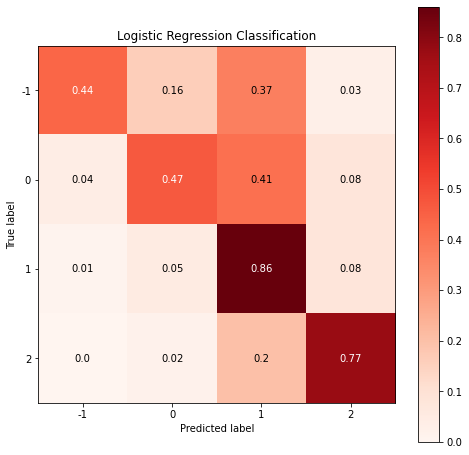

In [96]:
# Print a classification report

print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction))
plot_confusion_matrix(y_val, logreg_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Logistic Regression Classification')
plt.show()


**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.44
+ Neutral : 0.47
+ Pro : 0.86
+ News : 0.77

Just like the LinearSVC we see that Logistic Regression does a very good job at classifying positive classes


In [98]:
# Print the overall accuracy
logistic_reg_acc = round(accuracy_score(y_val, logreg_prediction),4)
print('\nLogistic Regression accuracy Score\n', logistic_reg_acc)
logistic_reg_f1 = round(f1_score(y_val, logreg_prediction, average="weighted"),4)
print('\nLogistic Regression weighted f1 score\n', logistic_reg_f1)



Logistic Regression accuracy Score
 0.7538

Logistic Regression weighted f1 score
 0.7453


### Evaluation of SGD Classifier

In [99]:
# Confusion matrix
print('\nSGD Classifier\n', confusion_matrix(y_val, SGD_prediction))


SGD Classifier
 [[ 130   44   91   13]
 [  32  170  177   46]
 [  37   84 1448  186]
 [   4   19  116  567]]



SGD Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.64      0.47      0.54       278
           0       0.54      0.40      0.46       425
           1       0.79      0.83      0.81      1755
           2       0.70      0.80      0.75       706

    accuracy                           0.73      3164
   macro avg       0.67      0.62      0.64      3164
weighted avg       0.72      0.73      0.72      3164



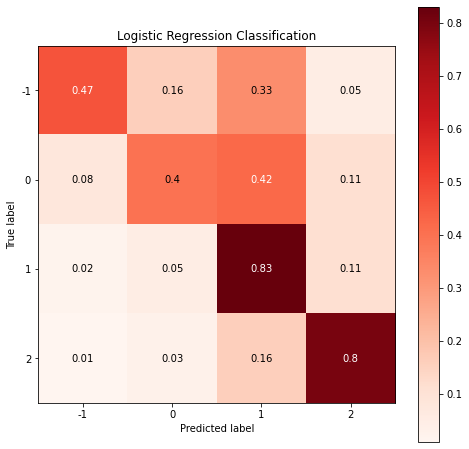

In [100]:
# The classification report 
print('\nSGD Classifier  Classification report :\n', classification_report(y_val, SGD_prediction))
plot_confusion_matrix(y_val, SGD_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Logistic Regression Classification')
plt.show()


**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.47
+ Neutral : 0.40
+ Pro : 0.83
+ News : 0.80

SGD classifier scored the highest in classification of positive classes for `anti` and `neutral` sentiment classes despite incorretly classsifying `anti` and `neutral` sentiment classes as `Pro` sentiment class 35% and 42% of the time respectively


- The SGD classifier is just as good at classifying `Pro` sentiment classs as the LinearSVC both achieving an f1 score of 0.84 however falls short in classifying the rest of the sentiment classes

In [101]:
# Checking the accuracy score
sgd_acc = round(accuracy_score(y_val, SGD_prediction),4)
print('\nSGD Classifier accuracy Score :\n', sgd_acc)

# Checking the f1_score report for the decison tree model
sgd_f1 = round(f1_score(y_val, SGD_prediction, average="weighted"),4)
print('\nSGD weighted avg f1_score :\n', sgd_f1)


SGD Classifier accuracy Score :
 0.7317

SGD weighted avg f1_score :
 0.7236


The overall accuracy score of the SGD classifier is 0.7317  and the wighted f1 score of 0.7236

### Support Vector Classfifier

In [103]:
# Confusion matrix 
print('\nSupport Vector Classifier\n', confusion_matrix(y_val, SVC_prediction))


Support Vector Classifier
 [[  62   32  175    9]
 [   5  141  232   47]
 [   3   38 1540  174]
 [   1   15  123  567]]



Support Vector Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.87      0.22      0.36       278
           0       0.62      0.33      0.43       425
           1       0.74      0.88      0.81      1755
           2       0.71      0.80      0.75       706

    accuracy                           0.73      3164
   macro avg       0.74      0.56      0.59      3164
weighted avg       0.73      0.73      0.70      3164



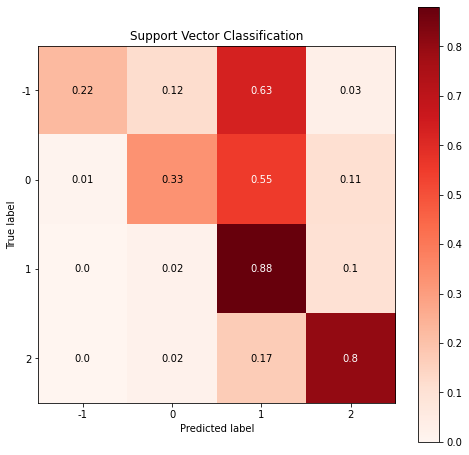

In [104]:
# The classification report 
print('\nSupport Vector Classifier  Classification report :\n', classification_report(y_val, SVC_prediction))
plot_confusion_matrix(y_val, SVC_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Support Vector Classification')
plt.show()


**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.22
+ Neutral : 0.33
+ Pro : 0.88
+ News : 0.80

The Support Vector Classifier incorrectly classfied over 50% of `neutral` tweets as `Pro` climate change tweets and 49% of `anti` sentiment class tweets as `Pro` sentiment class tweets

- Much like the `LinearSVC` we see that the  the `SVC` does a really good job at classifying `Pro` sentiment class with a score of 0.88, followed by the `News` sentiment class with an f1 score of over 0.20.
- Unlike most of the models we've build this far, the Support Vector Classifier struggle more with classifying the `Anti`sentiment class

In [105]:
# Checking the accuracy score
svc_acc = round(accuracy_score(y_val, SVC_prediction),4)
print(f'\nSupport Vector Classifier accuracy Score : {svc_acc}')
svc_f1 = round(f1_score(y_val, SVC_prediction, average="weighted"),4)
print(f'\nSupport Vector Classifier weighted avg f1 score : {svc_f1}')


Support Vector Classifier accuracy Score : 0.7301

Support Vector Classifier weighted avg f1 score : 0.7044


### Ridge Classifier

In [106]:
# Confusion matrix for the Ridge Classifier
print('\nRidge Classifier\n', confusion_matrix(y_val, ridge_prediction))


Ridge Classifier
 [[ 118   57   82   21]
 [  21  202  170   32]
 [  22   99 1466  168]
 [   4   29  139  534]]



Ridge Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.72      0.42      0.53       278
           0       0.52      0.48      0.50       425
           1       0.79      0.84      0.81      1755
           2       0.71      0.76      0.73       706

    accuracy                           0.73      3164
   macro avg       0.68      0.62      0.64      3164
weighted avg       0.73      0.73      0.73      3164



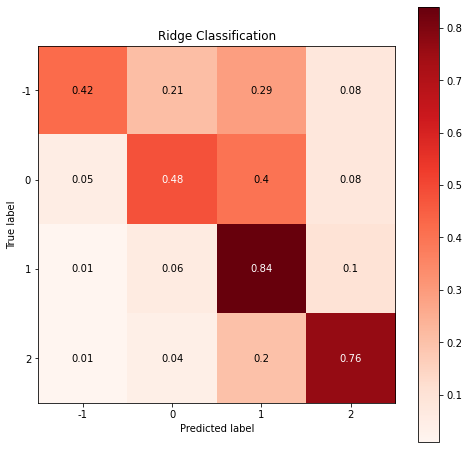

In [107]:
# The classification report 
print('\nRidge Classifier  Classification report :\n', classification_report(y_val, ridge_prediction))
plot_confusion_matrix(y_val, ridge_prediction, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Ridge Classification')
plt.show()

**Key Observations**

A Classification report is used to measure the quality of predictions from a classification algorithm.

The confusion matrix heatmap shows the model's  ability to classify positive samples, each class achieving a recall score of:

+ Anti Climate Change : 0.42
+ Neutral : 0.48
+ Pro : 0.84
+ News : 0.76

The major concern here is that the Ridge classification classified 40% of of `neutral` tweets as `Pro` climate change tweets



- Much like the `LinearSVC` we see that the  the `Ridge classifier` does a really good job at classifying `Pro` sentiment class with a score of 0.84, followed by the `News` sentiment class with an f1 score of over 0.76.
- Just like the support Vector Classifier, we see that Ridge Classifier does very good job at classifying the `anti` and `neutral` sentiment class

In [108]:
# Checking the accuracy score
ridge_acc = round(accuracy_score(y_val, ridge_prediction),4)
print(f'\nRidge Classifier accuracy Score : {ridge_acc}')
ridge_f1 = round(f1_score(y_val, ridge_prediction, average="weighted"),4)
print(f'\nRidge Classifier weighted avg f1 score : {ridge_f1}')


Ridge Classifier accuracy Score : 0.7332

Ridge Classifier weighted avg f1 score : 0.727


<a id='compare'></a>
## Model Comparision

Model comparison by accuracy and macro f1_score

In [109]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC',
                                    'Logistic Regression','Stochastic Gradient Descent',
                                    'Support Vector Classifier','Ridge Classifier'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,logistic_reg_acc, sgd_acc, svc_f1, ridge_acc],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,logistic_reg_f1, sgd_f1, svc_f1, ridge_f1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

,Classifiers,Accuracy,Weighted avg f1 Score
0,Decision Tree,0.6498,0.6403
5,Support Vector Classifier,0.7044,0.7044
1,Random Forest,0.7095,0.6797
4,Stochastic Gradient Descent,0.7317,0.7236
2,LinearSVC,0.7320,0.7273
6,Ridge Classifier,0.7332,0.7270
3,Logistic Regression,0.7538,0.7453


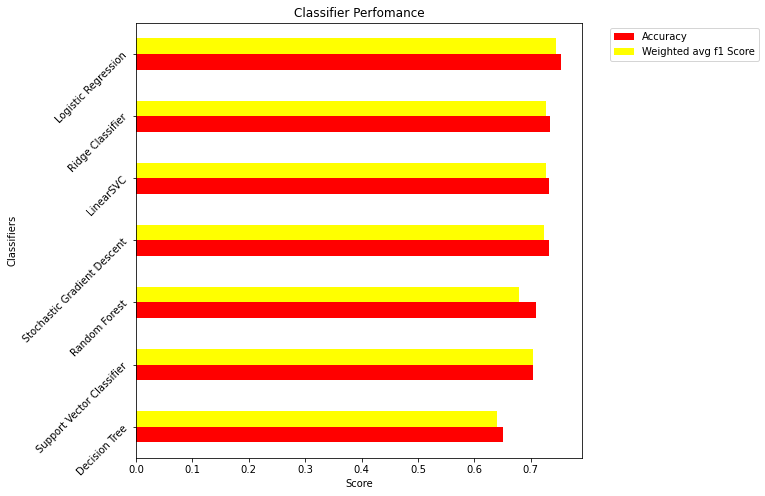

In [114]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='autumn')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

**Key observations**
From the above bar graph we see comparison of all the 7 models we've attempted thus far based on their `accuracy score` and associated `wighted f1 score`

- We see that our top 3 best performing models are `LinearSVC`,`Logistic Regression` and `Ridge Classification` respectively, theres are the models will use in ensemble methods to try and improve our results
- The `Decision Tree` classifer is the worst  at classifying the tweets with the lowest accuracy and wighted f1 scores of 0.64 and 0.61 respectivey

**LinearSVC is the best performing model out of all 7 models that we've tried thus far with an accuracy score of 0.7538 and a weighted f1 score of 0.7453**

<a id='ensemble'></a>
# Ensemble Methods

Ensemble learning in machine learning is the practice of combining multiple models to try and achieve higher overall model performance. In general, ensembles consist of multiple **heterogeneous or homogeneous** models trained on the same dataset. Each of these models is used to make predictions on the same input, then these predictions are aggregated across all models in some way (e.g. by taking the mean) to produce the final output.

<a id='ensemble'></a>
## Heterogeneous Ensembel Method
This type of ensemble consists of different types of models, so it can add pretty much any classification model we want, however in our case we're only going to add our top 3 best perfoming models which are, `LinearSVC, Stochastic Gradient Descent, Logistic Regression, `.

The Heterogeneous ensemble method we're going to look at is the `Voting classifier`


### Voting classifer 
Voting involves combining individual model outputs through a kind of "[majority rule](https://en.wikipedia.org/wiki/Majority_rule)" paradigm.
The diagram below shows how the `Voting Classifier` works
![ud382N9.png](https://iq.opengenus.org/content/images/2020/01/ud382N9.png)

In [31]:
# Define the models which we'll include in our ensemble.  
models = [("LinearSVC",Lsvc_count),("Logistic Regression",logreg_count),("Ridge Classified",ridge_count)]

# Specify weights for weighted model averaging
model_weightings = np.array([0.1,0.3,0.6])

# building the voting classifier
Voting_classifier = VotingClassifier(estimators=models,weights=model_weightings)


In [32]:
# training the voting classifier
Voting_classifier.fit(X_train, y_train)

C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('LinearSVC',
                              Pipeline(steps=[('CountVec',
                                               CountVectorizer(max_features=180000,
                                                               ngram_range=(1,
                                                                            2))),
                                              ('svc', LinearSVC())])),
                             ('Logistic Regression',
                              Pipeline(steps=[('CountVec',
                                               CountVectorizer(max_features=180000,
                                                               ngram_range=(1,
                                                                            2))),
                                              ('logistic',
                                               LogisticRegression())])),
                             ('Ridge Classified',
                              Pipeline(steps=[('CountVec',
                                               CountVectorizer(max_features=180000,
                                                               ngram_range=(1,
                                                                            2))),
                                              ('Ridge', RidgeClassifier())]))],
                 weights=array([0.1, 0.3, 0.6]))

In [33]:
# Voting Classifier predictions
voting_prediction = Voting_classifier.predict(X_val)

In [37]:
print('\nVoting Classifier  Classification report :\n', classification_report(y_val, voting_prediction))


Voting Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.72      0.42      0.53       278
           0       0.52      0.48      0.50       425
           1       0.79      0.84      0.81      1755
           2       0.71      0.76      0.73       706

    accuracy                           0.73      3164
   macro avg       0.68      0.62      0.64      3164
weighted avg       0.73      0.73      0.73      3164



The voting  classifer did a good job at classifying the sentiment classes which 'Neutral' sentiment class being the poorly classified one
- achieving the f1 score of
- `Pro` sentiment class : 0.81
- `News` sentiment class : 0.73
- `Anti` sentiment class: 0.53
- `Neutral` sentiment class : 0.50

In [38]:
# Checking the accuracy score
voting_acc = round(accuracy_score(y_val, voting_prediction),4)
print(f'\nOverall accuracy for the Voting Classifier : {voting_acc}')
voting_f1 = round(f1_score(y_val, voting_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for the Voting Classifier : {voting_f1}')


Overall accuracy for the Voting Classifier : 0.7332

Weighted avg f1 score for the Voting Classifier : 0.727


The Voting Classifier achieved the accuracy and weighted f1 score of 0.7332 and 0.727 respectively, which is not much of an improvement from our best performing model that achieved the accuracy of 0.75 and 0.74

<a id='tunning'></a>
# Hyperparameter Tunning
We will look at two methods of hyperparameter tunning, namely `GridSearchCV` and `Parfit`

* Models we will perform hyperparameter tunning on
  * LinearSVC
  * Logistic Regression
  * Ridge Classifier
 

The caveat of using pipelines to build our models is that we can't easily get the parameters for our models as such to perfom hyperparameter tunning and obtain the best parameters for our models we wont be using the pipelines, this means we will convert raw text data to numeric data independently from building the models.

In [34]:
# We have to to prepare our data again since we wont be using the pipelines

train = train.copy()
test = test.copy()

train['message'] = replace_sentiments(train)
test['message'] = replace_sentiments(test)
train['clean_tweets'] = clean_tweets(train)
test['clean_tweets'] = clean_tweets(test)

normalizer = WordNetLemmatizer()
train['clean_tweets'] = train['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])
test['clean_tweets'] = test['clean_tweets'].apply(lambda x: [normalizer.lemmatize(token, POS(token)) for token in x])



X = train['clean_tweets']
y = train['sentiment']
X_test = test['clean_tweets']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42)

X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))
X_test = list(X_test.apply(' '.join))

In [35]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

### Tuning LinearSVC

In [36]:
# The GridSearch Best parameter
best_param = {'C': 7.9060432109076855}

# retrain the model
grid_lsvc = LinearSVC(C= 7.9060432109076855)
grid_lsvc.fit(X_train, y_train)

C:\Users\tebel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=7.9060432109076855)

In [37]:
tuned_lsvc_predictions = grid_lsvc.predict(X_val)

In [43]:
# Checking the accuracy score
tuned_lsvc_acc = round(accuracy_score(y_val, tuned_lsvc_predictions),4)
print(f'\nOverall accuracy score for LinearSVC : {tuned_lsvc_acc}')


Overall accuracy score for LinearSVC : 0.732


In [38]:
# We now retrain the LinearSVC with the best parameters we got from the tuning method that performed the best

final_lsvc = LinearSVC(C=0.3906939937054613, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0) 
final_lsvc.fit(X_train, y_train)
LinearSVC_prediction = final_lsvc.predict(X_val)
final_svc_acc = accuracy_score(y_val, LinearSVC_prediction)
print(f'\nOverall accuracy score for LinearSVC : {final_svc_acc}')




Overall accuracy score for LinearSVC : 0.7597977243994943


In [39]:
# Saving the model
import pickle
model_save_path = 'final_lsvc.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(final_lsvc, file)

In [40]:
Final_lsvc_acc = accuracy_score(y_val, LinearSVC_prediction)
Final_lsvc_f1 = f1_score(y_val, LinearSVC_prediction, average = 'weighted')

In [41]:
# Saving the model
import pickle
model_save_path = 'vector.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(ridge_count, file)

### Tuning Logistic Regression

In [47]:
# Retraining the Logistic Regresion model with best parameters                     
grid_Log_reg = LogisticRegression(C = 3.727593720314938, penalty = 'l2',solver='lbfgs', random_state=42)
grid_Log_reg.fit(X_train, y_train)

tunned_logreg_acc = round(accuracy_score(y_val, grid_Log_reg.predict(X_val)),4)
print(f'The accuracy score score for tuned Logistic Regression Classifier : {tunned_logreg_acc}')

The accuracy score score for tuned Logistic Regression Classifier : 0.768


C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Saving the model
import pickle
model_save_path = 'Logistic_regression.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(grid_Log_reg, file)

In [42]:
# We now retrain Logistic Regression with the best parameters we got from the tuning method that performed the best

final_logreg = LogisticRegression(C = 3.727593720314938, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
final_logreg.fit(X_train, y_train)
final_log_reg_prediction= final_logreg.predict(X_val) 
final_logreg_acc = round(accuracy_score(y_val, final_log_reg_prediction),4)
final_logreg_acc

C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.768

In [43]:
final_logreg_f1 = round(f1_score(y_val, final_log_reg_prediction, average = 'weighted'),4)
final_logreg_f1

0.7596

## Tuning Ridge Classifier

In [44]:
best_params = {'alpha': 11.513953993264458}
# retrain the model with best params
ridge_grid = RidgeClassifier(alpha=11.513953993264458)
ridge_grid.fit(X_train, y_train)

RidgeClassifier(alpha=11.513953993264458)

In [45]:
# accuracy of the ridge gridsearch model
print(f1_score(y_val, ridge_grid.predict(X_val), average = 'weighted'))

0.7502744536332743


In [46]:
# retraining the best Ridge Classifer model we have
ridge_tuned = RidgeClassifier(alpha=5.428675439323859, class_weight=None, copy_X=True,
                fit_intercept=True, max_iter=None, normalize=False,
                random_state=None, solver='auto', tol=0.001) 
ridge_tuned.fit(X_train, y_train)

C:\Users\tebel\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


RidgeClassifier(alpha=5.428675439323859, normalize=False)

In [47]:
# Checking the accuracy score
ridge_prediction_tuned =ridge_tuned.predict(X_val)

ridge_acc_2 = round(accuracy_score(y_val, ridge_prediction_tuned),4)
print(f'\nOverall accuracy score for Ridge Classifier accuracy Score : {ridge_acc}')
ridge_f1_2 = round(f1_score(y_val, ridge_prediction_tuned, average="weighted"),4)
print(f'\nWeighted avg f1 score for Ridge Classifier : {ridge_f1}')


Overall accuracy score for Ridge Classifier accuracy Score : 0.7332490518331226


NameError: name 'ridge_f1' is not defined

In [48]:
# Saving the model
import pickle
model_save_path = 'Ridgeclfr.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(ridge_tuned, file)
  

<a id='final'></a>
# Final model selection

Comparing all the models we've build so far to choose the best performing one

In [49]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC'
                                    ,'Logistic Regression','Stochastic Gradient Descent',
                                    'Support Vector Classifier', 'Voting Classifer',
                                    'Tunned_LinearSVC','Tunned LogisticReg','Ridge Classifier', 'Tuned Ridge Classifier'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,logistic_reg_acc, sgd_acc, svc_f1, voting_acc
                                ,Final_lsvc_acc ,final_logreg_acc,
                                 ridge_acc, ridge_acc_2],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,logistic_reg_f1, sgd_f1, svc_f1,
                                              voting_f1, Final_lsvc_f1 ,final_logreg_f1, 
                                              ridge_f1, ridge_f1_2]}




df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df


df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

NameError: name 'decison_tree_acc' is not defined

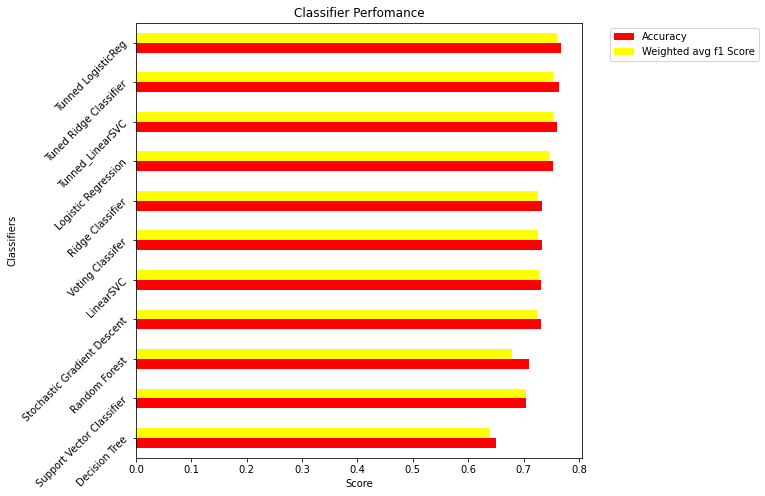

In [144]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='autumn')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We have build a total of 11 models in this notebook out of all the models we've build, We see that the best performing model is the tunned LogisticReg with the best accuracy score of 0.76 and the best weighted f1 score  of 0.76 based on the validation dataset, however for the unseen/test dataset the Ridge Classifier achieved the best score on Kaggle.

We will be using the **Ridge Regression** to make the final prediction.

## Final evaluation of our best model

In [145]:
print('classfication report for our best model\n',classification_report(y_val, ridge_tuned.predict(X_val)))

classfication report for our best model
               precision    recall  f1-score   support

          -1       0.79      0.46      0.58       126
           0       0.62      0.45      0.52       224
           1       0.79      0.88      0.83       895
           2       0.75      0.78      0.76       337

    accuracy                           0.76      1582
   macro avg       0.74      0.64      0.68      1582
weighted avg       0.76      0.76      0.75      1582



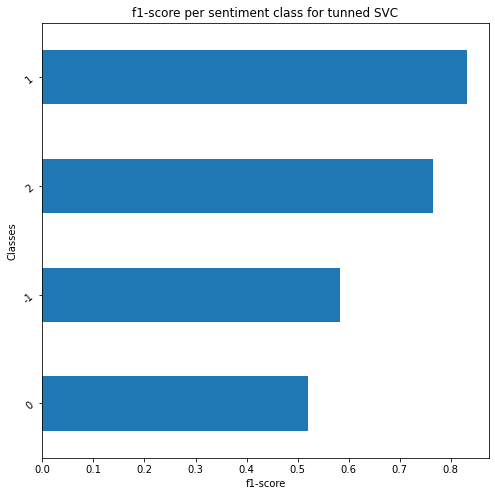

In [146]:
# # Visual represetation of of the f1 score for each class
report_ridge = classification_report(y_val, ridge_prediction_tuned, output_dict=True)
df_ridge = pd.DataFrame(report_ridge).transpose()
df_ridge.drop(['accuracy'], inplace = True)
df_ridge.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_ridge.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for tunned SVC')
plt.show()

The above bar graph shows the f1 score for each sentiment class our best model
- The Ridge Classifier is our best performing model, achieving f1 score of 0.83 for `Pro climate change` sentiment class, followed by `News` and `Anti` Climate sentiment classes with f1 scores of 0.76 and 0.58 respectively, which is quite impressive given that all our models perfomed poorly when it comes to classifying `anti climate change` sentiment class


## ROC Curves and AUC

ROC curves show the trade-off between sensitivity/recall known as the ability of a model to detect positive samples  and specificity also known as the `True Negative` rate.
classifiers that produce curves that are closer to the top left corner, that is closer to the 100% True positive rate are classifiers that are considerd to have better perfomance

C:\Users\lehut\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\lehut\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\lehut\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. P

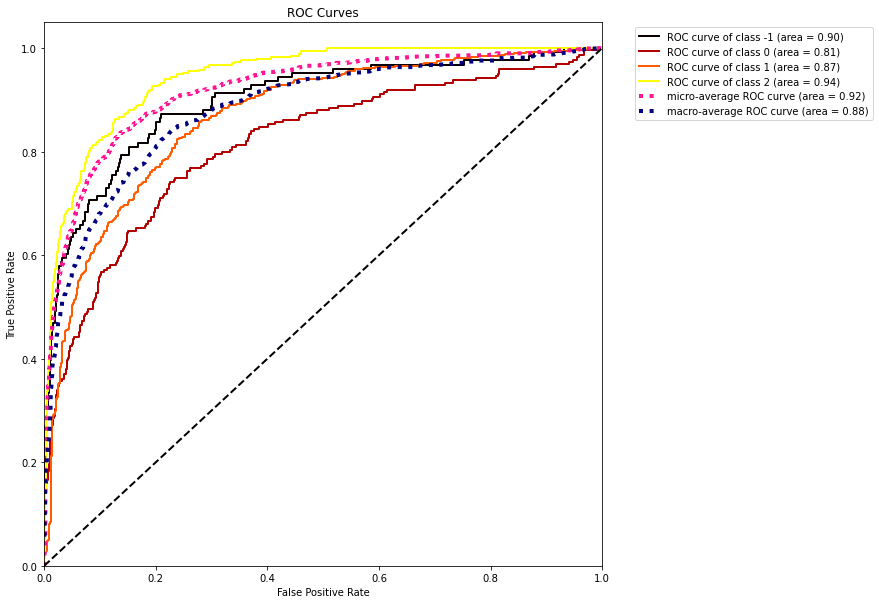

In [148]:
OneVsRest =  OneVsRestClassifier(RidgeClassifier(alpha=5.428675439323859, class_weight=None, copy_X=True,
                fit_intercept=True, max_iter=None, normalize=False,
                random_state=None, solver='auto', tol=0.001))
y_train_binarized = label_binarize(y_train, classes=[-1, 0, 1, 2])
y_val_binarized = label_binarize(y_val, classes=[-1, 0, 1, 2])
OneVsRest.fit(X_train, y_train_binarized)
y_prob = OneVsRest.decision_function(X_val)
plot_roc(y_val, y_prob,figsize=(10,10),cmap='hot')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<a id='predictions'></a>
# Final prediction

In [149]:
y_pred = ridge_tuned.predict(X_test)

In [150]:
y_pred

array([2, 0, 1, ..., 0, 0, 1], dtype=int64)

In [152]:
test['sentiment'] = y_pred

In [154]:
test[['tweetid','sentiment']].to_csv('Final Ridge Submission.csv', index=False)

In [156]:
test[['tweetid','sentiment']]

,tweetid,sentiment
0,169760,2
1,35326,0
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,0
10544,867455,0


<a id='conclusion'></a>
# Conclusion

In this notebook we have succesfully build 11 machine learning models to classify whether not a person believes in man made climate change based on their novel tweet data, Even though our models struggled with classifying the `anti` man made climate change sentiment class they did a very good job as classifying the `pro` man made climate change sentiment class. Our best model is the Ridge Classification model  achieving an accuracy score and the weighted f1 score of 0.76 and 0.76 respectively based on the validation dataset.

The Ridge classifier model achieved an F1 score of 0.76043 on unseen/test data.

Text classification problems tend to be quite high dimensionality and high dimensionality problems are likely to be linearly separable, So linear classifiers, whether ridge classification or SVM with a linear kernel, are likely to do well. In both cases, the ridge parameter or C for the SVM control the complexity of the classifier and help to avoid over-fitting by separating the patterns of each class by large margins as we can see in our final model comparision, our best models are linear classifiers

In [15]:
train.to_csv("df_train.csv",index=False)

In [14]:
train.head()

,sentiment,message,tweetid,hashtags,mentions,url,cleaned_tweets,no_stopwords,sent_labels,text_length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,NaN,[@mashable],[https://t.co/yelvcefxkc],"[polyscimajor, epa, chief, doesn't, think, car...","[polyscimajor, epa, chief, think, carbon, diox...",Pro,108
1,1,It's not like we lack evidence of anthropogeni...,126103,NaN,NaN,NaN,"[it's, not, like, we, lack, evidence, of, anth...","[like, lack, evidence, anthropogenic, global, ...",Pro,62
2,2,: Researchers say we have three years to act ...,698562,NaN,[@rawstory],"[https://t.co/wdt0kdur2f, https://t.co/z0anpt…]","[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...",News,86
3,1,WIRED : 2016 was a pivotal year in the war on...,573736,[#todayinmaker#],NaN,[https://t.co/44wotxtlcd],"[wired, 2016, was, pivotal, year, in, the, war...","[wired, 2016, pivotal, year, war, climate, cha...",Pro,62
4,1,": It's 2016, and a racist, sexist, climate ch...",466954,[#electionnight],[@soynoviodetodas],NaN,"[it's, 2016, and, racist, sexist, climate, cha...","[2016, racist, sexist, climate, change, denyin...",Pro,90


In [16]:
len(train["text_length"])

15819

In [ ]:
fixed_acidity = train["text_length"]
free_sulfur_dioxide = dataframe['free sulfur dioxide']
total_sulfur_dioxide = dataframe['total sulfur dioxide']
alcohol = dataframe['alcohol']

columns = [fixed_acidity, free_sulfur_dioxide, total_sulfur_dioxide, alcohol]

fig, ax = plt.subplots()
ax.boxplot(columns)
plt.show()

In [21]:
f = train[train['sentiment'] == 0]
g = f["text_length"]
g.head()

19    142
22     98
30     78
39    109
43    106
Name: text_length, dtype: int64

In [89]:
bf_world = hashtag_count(hashtags(train)).head(20)
bf_news = hashtag_count(hashtags(news_df))
bf_neutral = hashtag_count(hashtags(neutral_df)).head(20)
bf_anti = hashtag_count(hashtags(anti_df)).head(20)
bf_pro = hashtag_count(hashtags(pro_df)).head(20)

In [34]:
bf_world

,hashtags,count
18,#climate,344
23,#climatechange,188
21,#beforetheflood,154
51,#environment,73
143,#trump,70
4,#cop22,66
13,#imvotingbecause,62
70,#parisagreement,57
149,#globalwarming,43
87,#ã¢â‚¬â¦,39


In [91]:
bf_world_list = []
for i in bf_world["hashtags"]:
    bf_world_list.append(i)

bf_news_list = []
for i in bf_news["hashtags"]:
    bf_news_list.append(i)

bf_neutral_list = []
for i in bf_neutral["hashtags"]:
    bf_neutral_list.append(i)

bf_anti_list = []
for i in bf_anti["hashtags"]:
    bf_anti_list.append(i)
    
bf_pro_list = []
for i in bf_pro["hashtags"]:
    bf_pro_list.append(i)

In [104]:
bf_world_count_list = []
for i in bf_world["count"]:
    bf_world_count_list.append(i)

bf_news_count_list = []
for i in bf_news["count"]:
    bf_news_count_list.append(i)

bf_neutral_count_list = []
for i in bf_neutral["count"]:
    bf_neutral_count_list.append(i)

bf_anti_count_list = []
for i in bf_anti["count"]:
    bf_anti_count_list.append(i)
    
bf_pro_count_list = []
for i in bf_pro["count"]:
    bf_pro_count_list.append(i)

In [95]:
bf_world_dict = {}
for i in range(20):
    bf_world_dict[bf_world_list[i]] = bf_world_count_list[i]
    

In [96]:
bf_world_dict

{'#climate': 344,
 '#climatechange': 188,
 '#beforetheflood': 154,
 '#environment': 73,
 '#trump': 70,
 '#cop22': 66,
 '#imvotingbecause': 62,
 '#parisagreement': 57,
 '#globalwarming': 43,
 '#ã¢â‚¬â¦': 39,
 '#actonclimate': 38,
 '#science': 36,
 '#ivotedbecause': 33,
 '#news': 33,
 '#auspol': 27,
 '#maga': 24,
 '#climatemarch': 23,
 '#resist': 23,
 '#p2': 23,
 '#qanda': 19}

In [97]:
len(bf_world_dict)

20

In [105]:
bf_pro_dict = {}
for i in range(20):
    bf_pro_dict[bf_pro_list[i]] = bf_pro_count_list[i]

bf_anti_dict = {}
for i in range(20):
    bf_anti_dict[bf_anti_list[i]] = bf_anti_count_list[i]
    
bf_news_dict = {}
for i in range(20):
    bf_news_dict[bf_news_list[i]] = bf_news_count_list[i]
    
bf_neutral_dict = {}
for i in range(20):
    bf_neutral_dict[bf_neutral_list[i]] = bf_neutral_count_list[i]
    

In [108]:
bf_world.to_csv("bf_world.csv",index=False)
bf_pro.to_csv("bf_pro.csv",index=False)
bf_anti.to_csv("bf_anti.csv",index=False)
bf_news.to_csv("bf_news.csv",index=False)
bf_neutral.to_csv("bf_neutral.csv",index=False)

In [ ]:
accuracy_dict = {'TFIDF':[tfidf_avg_accuracy], 'CountVec':[CountVec]}
accuracy_df = pd.DataFrame(accuracy_dict)

In [26]:
CountVec

0.7203

In [27]:
tfidf_avg_accuracy

0.7143

In [50]:
vect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 1))
X = vect.fit_transform(train['message'])

In [51]:
# Saving the model
import pickle
model_save_path = 'vector2.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(vect, file)